In [4]:
## Load libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline

In [5]:
np.set_printoptions(precision=2)

In [6]:
import tensorflow as tf
import sys 
import pandas as pd

In [7]:
tf.__version__

'2.15.0'

In [8]:
from tensorflow.keras.datasets import mnist

In [9]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [10]:
# pca doesn't work with categorical variables. Autoencoder is a non linear dimension reduction tool. 

## Load MNIST data
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]* X_test.shape[2])


num_features = X_train.shape[1]
num_samples = X_train.shape[0]

In [11]:
#normalize the shapes
xmax =  np.amax(X_train)
xmin =  np.amin(X_train)
X_train = (X_train -xmin)/ (xmax -xmin)
X_test = (X_test -xmin)/ (xmax -xmin)

print(num_samples)
print(num_features)

60000
784


In [12]:
# parameters of autoencoder
batch_size = 256
max_epochs = 50
learning_rate = 1e-03
latent_dim = 128
hidden_dim = 256
original_dim = X_train.shape[1]

In [13]:
type(X_train) #loads into numpy array onlyy

numpy.ndarray

In [14]:
## convert numpy to tf.data.dataset
training_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)

In [15]:
# custom layers
#encoder
class Encoder(tf.keras.layers.Layer):
    # define input independent model information
    def __init__(self, hidden_dim, latent_dim):
        super(Encoder, self).__init__() #constructor is same for superclass
        self.encoder_layer1 =  tf.keras.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        self.encoder_layer2 = tf.keras.layers.Dense(units=latent_dim, activation=tf.nn.relu)    

    # method for forward propagation
    def call(self, input_features):
        a = self.encoder_layer1(input_features)
        a = self.encoder_layer2(a)
        return (a)


In [16]:
#decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.decoder_layer1 =  tf.keras.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        self.decoder_layer2 = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu) 

    def call(self, encoded_feature):
        a = self.decoder_layer1(encoded_feature)
        a = self.decoder_layer2(a)
        return a

In [17]:
# autoencoder
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim, hidden_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.loss = []
        self.encoder = Encoder(hidden_dim = hidden_dim, latent_dim = latent_dim) #calls constructor
        self.decoder = Decoder(latent_dim = latent_dim, hidden_dim = hidden_dim, original_dim = original_dim)

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed_features = self.decoder(encoded)
        return reconstructed_features



In [18]:
# build model
autoencoder = Autoencoder(latent_dim = latent_dim,
                          hidden_dim = hidden_dim,
                          original_dim = original_dim)

In [19]:
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate )

In [20]:
#custom training
def loss(true, pred):
    #pred = tf.cast(pred, tf.float32)
    #true = tf.cast(true, tf.float32)
    return tf.reduce_mean(tf.square(tf.subtract(true, pred)))

In [28]:
# custom training -  compute gradient of loss and update weights
@tf.function
def train(loss, model, opt , original_features):
    with tf.GradientTape() as g:
        pred = tf.cast(model(original_features), tf.float64)
        reconstruction_error =  loss(original_features, pred)
    
    gradients = g.gradient(reconstruction_error, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))

    return reconstruction_error

In [32]:
import time
# train network by iterating over epochs
# Varible to store training loss per epoch
loss_train_epoch = tf.keras.metrics.Mean()

#iterate over epochs
for epoch in range(max_epochs):
    start_time = time.time()
    epoch_loss = 0
    for step, train_batch_features in enumerate(training_dataset):
        loss_batch = train(loss, autoencoder, opt, train_batch_features)
   #append loss per epoch
    loss_train_epoch(loss_batch)
    print(f'Epoch {epoch+1}. loss = {loss_train_epoch.result()}' )
    print('Epoch %d: time taken = %.2fs, train loss = %f'%(epoch+1, time.time() - start_time, loss_train_epoch.result()))

Epoch 1. loss = 0.005336240865290165
Epoch 1: time taken = 1.55s, train loss = 0.005336
Epoch 2. loss = 0.005348077975213528
Epoch 2: time taken = 1.51s, train loss = 0.005348
Epoch 3. loss = 0.005384488496929407
Epoch 3: time taken = 1.56s, train loss = 0.005384
Epoch 4. loss = 0.005374573171138763
Epoch 4: time taken = 1.55s, train loss = 0.005375
Epoch 5. loss = 0.0053656091913580894
Epoch 5: time taken = 1.50s, train loss = 0.005366
Epoch 6. loss = 0.005366146098822355
Epoch 6: time taken = 1.56s, train loss = 0.005366
Epoch 7. loss = 0.0053571839816868305
Epoch 7: time taken = 1.66s, train loss = 0.005357
Epoch 8. loss = 0.005354090128093958
Epoch 8: time taken = 1.58s, train loss = 0.005354
Epoch 9. loss = 0.005342843011021614
Epoch 9: time taken = 1.59s, train loss = 0.005343
Epoch 10. loss = 0.005336232483386993
Epoch 10: time taken = 1.59s, train loss = 0.005336
Epoch 11. loss = 0.005334449931979179
Epoch 11: time taken = 1.71s, train loss = 0.005334
Epoch 12. loss = 0.0053399

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(4, 4))
fig.tight_layout(pad=5.0)
pd.Series(loss_train_epoch).plot(ax=ax[0], color='b')
ax[0].set_xlabel('Epochs', fontsize=15)
ax[0].set_ylabel('Loss', fontsize=15)
ax[0].legend()
ax[0].set_title('Loss vs. Epoch', fontsize=15)


In [ ]:
train_loop(autoencoder, opt, loss, training_dataset, max_epochs)

C:\Users\SA RAVI\AppData\Local\Temp\ipykernel_17784\3907480142.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, nimages, ind + 1)


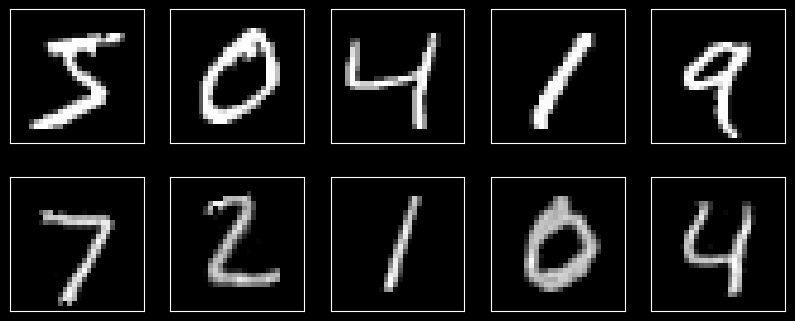

In [27]:
nimages = 5
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for ind in range(nimages):
    ax = plt.subplot(2, nimages, ind + 1)
    plt.imshow(X_train[ind].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #reconstructed images
    ax = plt.subplot(2, nimages, ind + 1 + nimages)
    plt.imshow(autoencoder(X_test)[ind].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()